In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat
from scipy.interpolate import interp1d
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# LOAD BOTTOM SLOPES 
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/slopes/CM26_slope_rough_1degree.mat')
lon0 = x['lon'][:,0]
lat = x['lat'][:,0]
gamma0 = x['zonal'] # eastward 
alpha0 = x['meridional'] # northward 
roughness = x['rms_rough']
# realign so lon-grid goes from 0-360
roughness = np.concatenate((roughness[:,lon0 >= 0], roughness[:,lon0 < 0]),axis=1)
alpha0 = np.concatenate((alpha0[:,lon0 >= 0], alpha0[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((gamma0[:,lon0 >= 0], gamma0[:,lon0 < 0]),axis=1)
lon = np.concatenate((lon0[lon0 >= 0], lon0[lon0 < 0]+360))

In [11]:
# bathy 
cm26_bathy_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_depth.nc'
cmbathy = xr.open_dataset(cm26_bathy_path)
depth = cmbathy.depth.data[::10,::10]
depth = np.concatenate((depth[:,lon0UV >= 0], depth[:,lon0UV < 0].data),axis=1)

In [5]:
# LOAD EOFS
cm26_eof_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_EOF12_analysis.nc'
cmEOF = xr.open_dataset(cm26_eof_path)
# shift EOF longitudes to match with modes 
lon01 = cmEOF.lon.data
eofu1 = np.concatenate((cmEOF.EOF1u[:,:,lon01 >= 0].data, cmEOF.EOF1u[:,:,lon01 < 0].data),axis=2)
eofv1 = np.concatenate((cmEOF.EOF1v[:,:,lon01 >= 0].data, cmEOF.EOF1v[:,:,lon01 < 0].data),axis=2)
eofu2 = np.concatenate((cmEOF.EOF2u[:,:,lon01 >= 0].data, cmEOF.EOF2u[:,:,lon01 < 0].data),axis=2)
eofv2 = np.concatenate((cmEOF.EOF2v[:,:,lon01 >= 0].data, cmEOF.EOF2v[:,:,lon01 < 0].data),axis=2)
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = cmEOF.lat.data
data_coords = {'depth': cmEOF.zl.data, 'latitude': lat1, 'longitude': lon1}
EOF1u = xr.DataArray(data=eofu1, dims=['depth','latitude','longitude'], coords=data_coords) 
EOF1v = xr.DataArray(data=eofv1, dims=['depth','latitude','longitude'], coords=data_coords) 
EOF2u = xr.DataArray(data=eofu2, dims=['depth','latitude','longitude'], coords=data_coords) 
EOF2v = xr.DataArray(data=eofv2, dims=['depth','latitude','longitude'], coords=data_coords) 
# trim in lat to match N2 data (maybe not needed)
EOF1u_trim = EOF1u[:,4:-25,:]
EOF1v_trim = EOF1v[:,4:-25,:]
EOF2u_trim = EOF2u[:,4:-25,:]
EOF2v_trim = EOF2v[:,4:-25,:]
lat_trim = lat1[4:-25]
EOF_z = cmEOF.zl.data

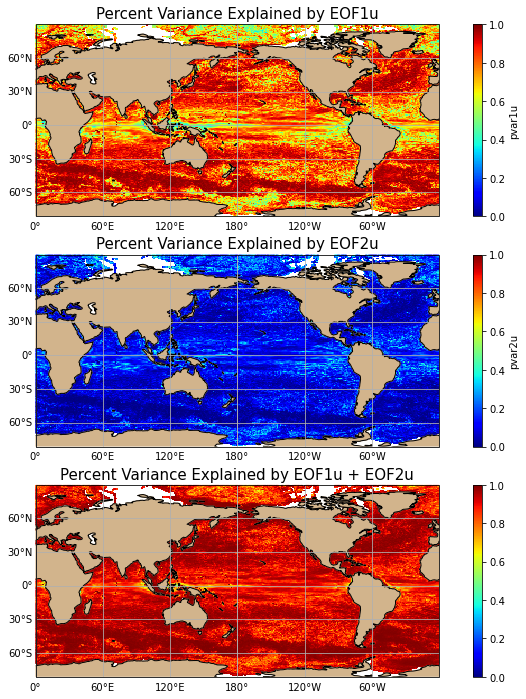

In [4]:
# percent var explained by EOFs 1+2
pvaru12 = cmEOF.pvar1u + cmEOF.pvar2u
f, (ax,ax2,ax3) = plt.subplots(3,1,figsize=(12,12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
cmEOF.pvar1u.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), add_colorbar=True, vmin=0,vmax=1) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('Percent Variance Explained by EOF1u',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
cmEOF.pvar2u.plot(ax=ax2,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), add_colorbar=True, vmin=0,vmax=1) 
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines(); gl = ax2.gridlines(draw_labels=True)
ax2.set_title('Percent Variance Explained by EOF2u',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
pvaru12.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), add_colorbar=True, vmin=0,vmax=1) 
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax3.coastlines(); gl = ax3.gridlines(draw_labels=True)
ax3.set_title('Percent Variance Explained by EOF1u + EOF2u',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_22/eof_pct_var.jpg', dpi=300)

In [4]:
# DO I NEED THIS? 
# BT / BC ratio for total KE 
cm26_ratio = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_Ratio_BTBC_KE_mean.nc'
CMratio_mean = xr.open_dataset(cm26_ratio)
BT_BC_mean = CMratio_mean.Ratio_BTBC_KE.data
BT_BC_mean = np.concatenate((BT_BC_mean[:,lon0 >= 0], BT_BC_mean[:,lon0 < 0]),axis=1)
BT_BC_mean_dec = BT_BC_mean[::4,::4]
roughness_dec = roughness[::4,::4]

In [6]:
cm26_scales_fn = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_scales_and_clusters.nc'
cm26_scales = xr.open_dataset(cm26_scales_fn)
LE_scale = cm26_scales.LE_scale.data
LD_scale = cm26_scales.LD_QG.data
LRh_scale = cm26_scales.L_rhines.data
LE_scale = np.concatenate((LE_scale[:,lon01 >= 0], LE_scale[:,lon01 < 0]),axis=1)
LD_scale = np.concatenate((LD_scale[:,lon01 >= 0], LD_scale[:,lon01 < 0]),axis=1)
LRh_scale = np.concatenate((LRh_scale[:,lon01 >= 0], LRh_scale[:,lon01 < 0]),axis=1)
scale_ratio = LE_scale/LD_scale

(-75.0, 75.0)

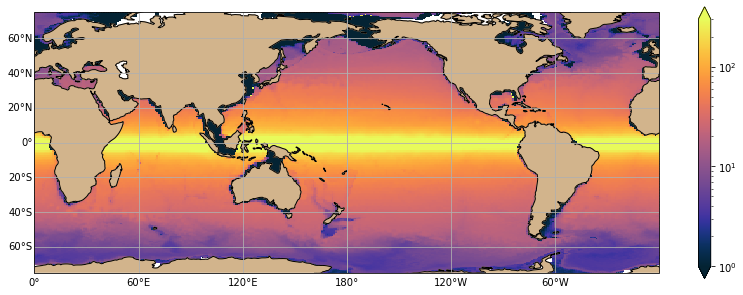

In [6]:
data_coords = {'latitude': lat1, 'longitude': lon1}
LD_da = xr.DataArray(data=LD_scale, dims=['latitude', 'longitude'], coords=data_coords) 
LRh_da = xr.DataArray(data=LE_scale, dims=['latitude', 'longitude'], coords=data_coords) 
f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
LD_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal, add_colorbar=True,norm=LogNorm(vmin=1,vmax=300))
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True);
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
# ax.set_title('NOAA GFDL CM2.6 Mean Barotropic KE [m$^{2}$s$^{-2}$]',fontsize=15)

In [157]:
# histogram per latitude step (each integrates to 1)
hh = np.nan*np.ones((np.shape(BT_BC_mean_dec)[0],50))
hh1 = np.nan*np.ones((np.shape(BT_BC_mean_dec)[0],50))
for i in range(np.shape(BT_BC_mean_dec)[0]):
    # if np.sum(np.isnan(BT_BC_mean_dec[i,:])) < np.int(len(BT_BC_mean_dec[i,:])/2):
    good = ~np.isnan(BT_BC_mean_dec[i,:])
    h0, be = np.histogram(BT_BC_mean_dec[i,good],bins=50,range=[0,3],density=True)
    hh[i,:] = h0
    h1, be = np.histogram(roughness_dec[i,good],bins=50,range=[0,500],density=True)
    hh1[i,:] = h1

In [854]:
# f, ax = plt.subplots(1,1,figsize=(8,5))
# ax.pcolor(lat[::4],np.linspace(0,3,50),np.transpose(hh),vmin=0,vmax=3)
# # ax.contour(lat[::4],np.linspace(0,3,50),np.transpose(hh),levels=[0.65,1],colors='w',linewidths=0.5)
# ax.contour(lat[::4],np.linspace(0,3,50),np.transpose(hh1),vmin=0,vmax=5)
# ax.set_xlim([-75,75])

In [7]:
# Percent Decay (EOF1)
pct_decay = np.nan*np.ones((len(lat_trim),len(lon1))); pct_decay_v = np.nan*np.ones((len(lat_trim),len(lon1)))
for i in tqdm(range(len(lon1))):
    for j in range(len(lat_trim)):
        if len(np.where(~np.isnan(EOF1u_trim[:,j,i]))[0]) > 5:
            gi = np.where(~np.isnan(EOF1u_trim[:,j,i]))[0]
            pct_decay[j,i] = np.nanmean(EOF1u_trim[gi[-4:],j,i]) / np.nanmean(EOF1u_trim[0:4,j,i])
            pct_decay_v[j,i] = np.nanmean(EOF1v_trim[gi[-4:],j,i]) / np.nanmean(EOF1v_trim[0:4,j,i])

100%|██████████| 360/360 [02:06<00:00,  2.85it/s]


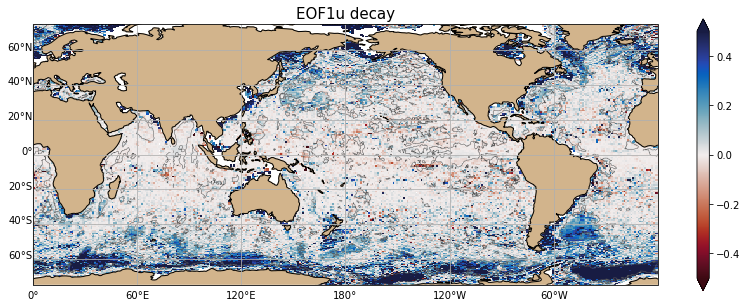

In [718]:
data_coords = {'latitude': lat_trim, 'longitude': lon1}
pct_decay_da = xr.DataArray(data=pct_decay, dims=['latitude', 'longitude'], coords=data_coords) 
f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
pct_decay_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.balance_r, add_colorbar=True, vmin=-0.5, vmax=0.5)
ax.contour(lon,lat,roughness,levels=[75],colors='#5b5b5b',transform=ccrs.PlateCarree(),linewidths=0.5)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); ax.set_title(r'EOF1u decay',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_22/eof_decay.jpg', dpi=300)

In [8]:
# LOAD CM MKE (defined using barotropic velocities)
cm26_BTuv_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_Barotropic_velocities.nc'
cmMKE = xr.open_dataset(cm26_BTuv_path)
lon0BT = cmMKE.xu_ocean.data
BTu = np.concatenate((cmMKE.u_BT[:,lon0BT >= 0].data, cmMKE.u_BT[:,lon0BT < 0].data),axis=1)
BTv = np.concatenate((cmMKE.v_BT[:,lon0BT >= 0].data, cmMKE.v_BT[:,lon0BT < 0].data),axis=1)
MKE0 = 0.5*(BTu**2 + BTv**2)
lonBT = np.concatenate((lon0BT[lon0BT >= 0], lon0BT[lon0BT < 0]+360))
latBT = cmMKE.yu_ocean.data
data_coords = {'latitude': latBT[::2], 'longitude': lonBT[::2]}
MKE = xr.DataArray(data=MKE0[::2,::2], dims=['latitude', 'longitude'], coords=data_coords) 

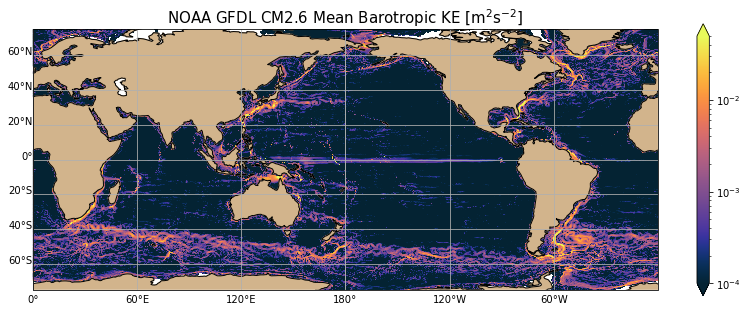

In [704]:
f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
MKE.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal, add_colorbar=True, norm=LogNorm(vmin=0.001, vmax=0.05))
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True);
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
ax.set_title('NOAA GFDL CM2.6 Mean Barotropic KE [m$^{2}$s$^{-2}$]',fontsize=15)
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_22/bt_ke.jpg', dpi=300)

In [9]:
# LOAD CM UV compute true MEKE 
cm26_u_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_u_1year.nc'
cm26_v_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_v_1year.nc'
cmU = xr.open_dataset(cm26_u_path); cmV = xr.open_dataset(cm26_v_path)
lon0UV = cmU.xu_ocean.data
U = np.concatenate((cmU.u_full[:,:,:,lon0UV >= 0].data, cmU.u_full[:,:,:,lon0UV < 0].data),axis=3)
V = np.concatenate((cmV.v_full[:,:,:,lon0UV >= 0].data, cmV.v_full[:,:,:,lon0UV < 0].data),axis=3)
EKE0 = 0.5*(np.nanmean(U[:,0],axis=0)**2 + np.nanmean(V[:,0],axis=0)**2)
lonUV = np.concatenate((lon0UV[lon0UV >= 0], lon0UV[lon0UV < 0]+360))
latUV = cmV.yu_ocean.data
data_coords = {'latitude': latUV, 'longitude': lonUV}
EKE = xr.DataArray(data=EKE0, dims=['latitude', 'longitude'], coords=data_coords) 
z_mid = cmU.st_ocean.data
z_edge = np.concatenate((np.array([0]), z_mid[0:-1] + (z_mid[1:]-z_mid[0:-1])/2))

In [10]:
# compute u prime so we can generate BT/BC ratios for EKE (not total KE)
U_pr = U - np.nanmean(U,axis=0); V_pr = V - np.nanmean(V,axis=0)

In [12]:
# my own BT/BC ratio (set up to do either KE or EKE)
BTU = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BTV = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
MKE_t = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BTKE = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BCKE = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
bottom_ke = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BCU = np.nan*np.ones(np.shape(U)); BCV = np.nan*np.ones(np.shape(U))
for t in tqdm(range(np.shape(U)[0])):
    for i in range(np.shape(U)[2]):
        for j in range(np.shape(U)[3]):
            this_u = U_pr[t,:,i,j]; this_v = V_pr[t,:,i,j]; good = ~np.isnan(this_u)
            if np.sum(good) > 3:
                this_z = np.concatenate((z_edge[good], np.array([depth[i,j]])))
                this_dz = this_z[1:]-this_z[0:-1]
                BTU[t,i,j] = (1/depth[i,j])*np.sum(this_u[good]*this_dz)
                BTV[t,i,j] = (1/depth[i,j])*np.sum(this_v[good]*this_dz)   
                BCU[t,good,i,j] = this_u[good] - BTU[t,i,j]
                BCV[t,good,i,j] = this_v[good] - BTV[t,i,j]   
                MKE_t[t,i,j] = 0.5*(np.sum((this_u[good]**2)*this_dz) +  np.sum((this_v[good]**2)*this_dz))
                BTKE[t,i,j] = 0.5*(BTU[t,i,j]**2 + BTV[t,i,j]**2)
                BCKE[t,i,j] = (1/depth[i,j])*np.sum( 0.5*((this_u[good] - BTU[t,i,j])**2 + (this_v[good] - BTV[t,i,j])**2)*this_dz )
                bottom_ke[t,i,j] = 0.5*(U[t,:,i,j][good][-1]**2 + V[t,:,i,j][good][-1]**2)

100%|██████████| 73/73 [07:26<00:00,  6.12s/it]


In [13]:
# time mean 
BT_BC_EKE = np.nanmean(BTKE,axis=0)/np.nanmean(BCKE,axis=0)
MKE = np.nanmean(MKE_t,axis=0)
mean_bottom_ke = np.nanmean(bottom_ke,axis=0)

(-75.0, 75.0)

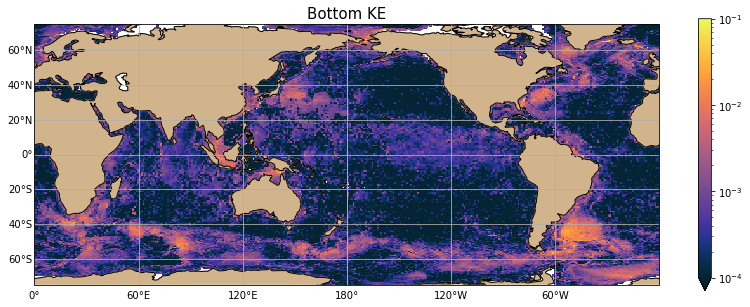

In [14]:
# check that it works and looks like BT/BC for total KE
data_coords = {'latitude': latUV, 'longitude': lonUV}
BT_BC_EKE_da = xr.DataArray(data=BT_BC_EKE, dims=['latitude', 'longitude'], coords=data_coords) 
MKE_da = xr.DataArray(data=MKE, dims=['latitude', 'longitude'], coords=data_coords) 
botke_da = xr.DataArray(data=mean_bottom_ke, dims=['latitude', 'longitude'], coords=data_coords) 

f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# BT_BC_EKE_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal, add_colorbar=True, norm=LogNorm(vmin=0.1, vmax=10))
# MKE_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal, add_colorbar=True, norm=LogNorm(vmin=0.1, vmax=20))
botke_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal, add_colorbar=True, norm=LogNorm(vmin=0.0001, vmax=0.1))
# ax.contour(lon,lat,roughness,levels=[75],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); 
# ax.set_title(r'Mean BT/BC EKE [m$^{2}$s$^{-2}$]',fontsize=15)
# ax.set_title(r'MKE = $\int_{z=-H}^{z=0} \frac{1}{2}(u^2 + v^2) dz$',fontsize=15)
ax.set_title('Bottom KE',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
# cbpos = [0.92, 0.12, 0.01, 0.6]; cax = f.add_axes(cbpos);
# cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_12_20/bot_vel.jpg', dpi=300)

In [15]:
# LOAD CMN2 (to compare clusters against stratifaction)
cm26_n2_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_N2_gsw.nc'
cmN2 = xr.open_dataset(cm26_n2_path)
lon02 = cmN2.xu_ocean.data
N2_s = np.concatenate((cmN2.N2[:,:,lon02 >= 0].data, cmN2.N2[:,:,lon02 < 0].data),axis=2)
N2_s_z = cmN2.depth.data
lon2 = np.concatenate((lon02[lon02 >= 0], lon02[lon02 < 0]+360))
lat2 = cmN2.yu_ocean.data

N2_max = np.nanmax(N2_s,axis=0)
N2_mid = N2_s[19] #19=300m,32=2000m
decay_N2 = N2_max/N2_mid

(-75.0, 75.0)

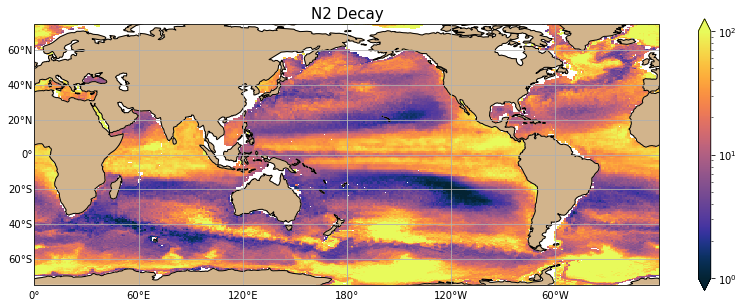

In [97]:
# check that it works and looks like BT/BC for total KE
data_coords = {'latitude': lat2, 'longitude': lon2}
n2_decay_da = xr.DataArray(data=decay_N2, dims=['latitude', 'longitude'], coords=data_coords) 

f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
n2_decay_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal, add_colorbar=True, norm=LogNorm(vmin=1, vmax=100))
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); 
ax.set_title('N2 Decay',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_12_20/bot_vel.jpg', dpi=300)

In [28]:
# -- LOAD ARGO N2 (for now match N2 to CM2.6 grid)
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/slopes/global_1deg_N2smooth_slope.mat') # global_n2_2deg_slope.mat')
N2_lon = x['lon'][:,0]    
# N2_lon[N2_lon < 0] = 360-np.abs(N2_lon[N2_lon < 0])
N2_lat = x['lat'][:,0]   
N2 = x['N2']      
N2 = np.concatenate((N2[N2_lon < 180,:,:], N2[N2_lon > 180,:,:]),axis=0)
N2_z = -1.*x['dep'][:,0]
# -- LOAD ARGO DENSITY (BETTER EFOLDING SCALE EST)
x = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/Argo/Argo_rho_decay_dep_2018.nc')
H_topo = x['depth'].data
decay = np.nanmean(x['decay'],axis=0)/H_topo
lon_d = x['longitude'].data; lat_d = x['latitude'].data

In [545]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
cc = ax.pcolor(lon2,lat2,np.nanmean(x['decay'],axis=0),vmin=0,vmax=5000,transform=ccrs.PlateCarree(),cmap=cmo.cm.thermal)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); # ax.set_title(r'Mean Surface EKE [m$^{2}$s$^{-2}$]',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
cbpos = [0.92, 0.15, 0.02, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='density')

(12, 145, 360)

In [16]:
# flip sign for subsequent characterization
eof1u = np.nan*np.ones(np.shape(EOF1u)); eof1v = np.nan*np.ones(np.shape(EOF1u))
eof2u = np.nan*np.ones(np.shape(EOF2u)); eof2v = np.nan*np.ones(np.shape(EOF2u))
for i in tqdm(range(np.shape(EOF1u)[1])):
    for j in range(np.shape(EOF1u)[2]):
        this_eofu = EOF1u[:,i,j].data
        if np.nanmean(this_eofu[0:15]) < 0:
            this_eofu = this_eofu*-1
        eof1u[:,i,j] = this_eofu
        this_eofv = EOF1v[:,i,j].data
        if np.nanmean(this_eofv[0:15]) < 0:
            this_eofv = this_eofv*-1
        eof1v[:,i,j] = this_eofv
        
        this_eofu = EOF2u[:,i,j].data
        if np.nanmean(this_eofu[0:15]) < 0:
            this_eofu = this_eofu*-1
        eof2u[:,i,j] = this_eofu
        this_eofv = EOF2v[:,i,j].data
        if np.nanmean(this_eofv[0:15]) < 0:
            this_eofv = this_eofv*-1
        eof2v[:,i,j] = this_eofv

100%|██████████| 270/270 [01:09<00:00,  3.89it/s]


In [17]:
lat_band = range(10,250) # move forward with subset in lat, prep for depth manipulation  
eof1u_t = eof1u[:,lat_band,:]; eof1v_t = eof1v[:,lat_band,:]
eof2u_t = eof2u[:,lat_band,:]; eof2v_t = eof2v[:,lat_band,:]
X_train0 = np.reshape(eof1u_t,(np.shape(eof1u_t)[0],np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
X_train1 = np.reshape(eof1v_t,(np.shape(eof1v_t)[0],np.shape(eof1v_t)[1]*np.shape(eof1v_t)[2]))
X_train2 = np.reshape(eof2u_t,(np.shape(eof2u_t)[0],np.shape(eof2u_t)[1]*np.shape(eof2u_t)[2]))
X_train3 = np.reshape(eof2v_t,(np.shape(eof2v_t)[0],np.shape(eof2v_t)[1]*np.shape(eof2v_t)[2]))

Text(0, 0.5, 'depth [m]')

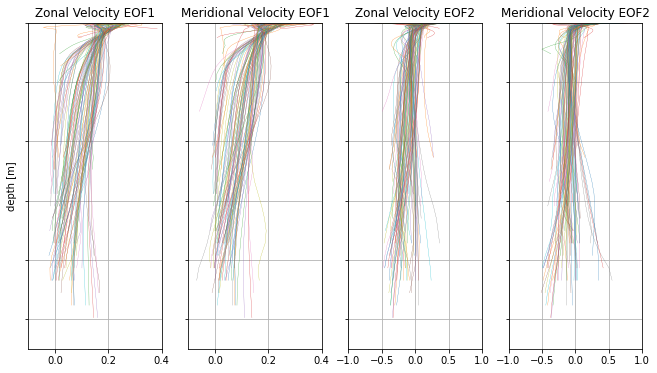

In [18]:
# sample non-rescaled 
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(11,6),sharey=True)
for i in range(0,30,2):
    for j in range(0,30,2):
        ax1.plot(eof1u_t[:,i,j],EOF_z,linewidth=0.25)
        ax2.plot(eof1v_t[:,i,j],EOF_z,linewidth=0.25)
        ax3.plot(eof2u_t[:,i,j],EOF_z,linewidth=0.25)
        ax4.plot(eof2v_t[:,i,j],EOF_z,linewidth=0.25)
ax1.set_ylim([0,5500]); ax1.invert_yaxis(); ax1.grid(); ax1.set_xlim([-0.1,0.4])
ax2.set_ylim([0,5500]); ax2.invert_yaxis(); ax2.grid(); ax2.set_xlim([-0.1,0.4]); ax2.set_yticklabels('')
ax3.set_xlim([-1,1]); ax4.set_xlim([-1,1]); ax3.grid(); ax4.grid();
ax1.set_title('Zonal Velocity EOF1')
ax2.set_title('Meridional Velocity EOF1')
ax3.set_title('Zonal Velocity EOF2')
ax4.set_title('Meridional Velocity EOF2')
ax1.set_ylabel('depth [m]')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/sample_eofs.jpg', dpi=300)

In [19]:
# OPTION 2
# rescale in depth so surface is zero and bottom is one 
rs_grid = np.arange(0,1,0.02)
rs_train_u = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
rs_train_v = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
rs_train_u2 = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
rs_train_v2 = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
for i in tqdm(range(np.shape(X_train0)[1])): #range(916,917): # 
    this_p_u = X_train0[:,i] 
    this_p_v = X_train1[:,i]
    this_p2_u = X_train2[:,i] 
    this_p2_v = X_train3[:,i]
    if np.sum(np.isnan(this_p_u)) > (len(this_p_u) - 5):
        continue
    g = np.where(~np.isnan(this_p_u))[0]
    max_dep = np.nanmax(EOF_z[g])
    if (len(g) > 10) & (np.nanmax(EOF_z[g]) > 1000):
        rs_train_u[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p_u[g])
        rs_train_v[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p_v[g])
        rs_train_u2[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p2_u[g])
        rs_train_v2[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p2_v[g])
good = np.where(~np.isnan(rs_train_u[10,:]))[0] # stack profiles (only include those deeper than ... and not over land)
rs_train_u = rs_train_u[:,good]; 
rs_train_v = rs_train_v[:,good];
X_trainU = rs_train_u; 
X_trainV = rs_train_v;

rs_train_u2 = rs_train_u2[:,good]; rs_train_v2 = rs_train_v2[:,good]
X_trainU2 = rs_train_u2; X_trainV2 = rs_train_v2

100%|██████████| 86400/86400 [00:03<00:00, 28431.89it/s]


In [20]:
# pct var, collapse to 1d list
cmpvaru1 = np.concatenate((cmEOF.pvar1u[:,lon01 >= 0].data, cmEOF.pvar1u[:,lon01 < 0].data),axis=1)
cmpvarv1 = np.concatenate((cmEOF.pvar1v[:,lon01 >= 0].data, cmEOF.pvar1v[:,lon01 < 0].data),axis=1)
cmpvaru2 = np.concatenate((cmEOF.pvar2u[:,lon01 >= 0].data, cmEOF.pvar2u[:,lon01 < 0].data),axis=1)
cmpvarv2 = np.concatenate((cmEOF.pvar2v[:,lon01 >= 0].data, cmEOF.pvar2v[:,lon01 < 0].data),axis=1)
pct_var_u1 = np.reshape(cmpvaru1[lat_band,:],(1,np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))[0,good]
pct_var_v1 = np.reshape(cmpvarv1[lat_band,:],(1,np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))[0,good]
pct_var_u2 = np.reshape(cmpvaru2[lat_band,:],(1,np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))[0,good]
pct_var_v2 = np.reshape(cmpvarv2[lat_band,:],(1,np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))[0,good]
# roughness, collapse to 1d list
roughness_list = np.reshape(roughness[::10,::10][lat_band,:],(1,np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))[0,good]

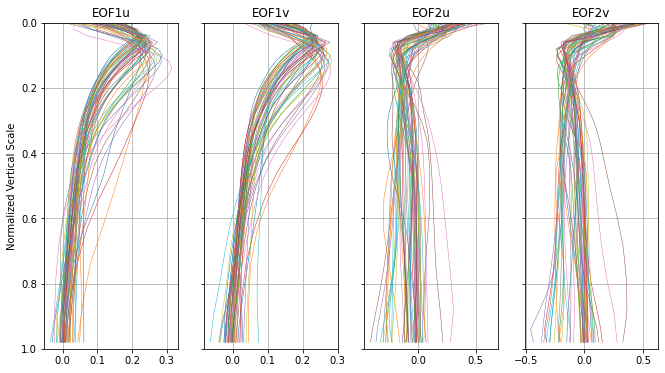

In [21]:
# sample set of rescaled profiles (OPTION 2)
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(11,6))
for i in range(50):
    ax1.plot(rs_train_u[:,i],rs_grid,linewidth=0.5)
    ax2.plot(rs_train_v[:,i],rs_grid,linewidth=0.5)
    ax3.plot(rs_train_u2[:,i],rs_grid,linewidth=0.5)
    ax4.plot(rs_train_v2[:,i],rs_grid,linewidth=0.5)
ax1.set_ylim([0,1]); ax1.invert_yaxis(); ax1.set_ylabel('Normalized Vertical Scale')
ax2.set_ylim([0,1]); ax2.invert_yaxis(); ax2.set_yticklabels('')
ax3.set_ylim([0,1]); ax3.invert_yaxis(); ax3.set_yticklabels('')
ax4.set_ylim([0,1]); ax4.invert_yaxis(); ax4.set_yticklabels('')
ax1.grid();ax2.grid();ax3.grid();ax4.grid();
ax1.set_title('EOF1u');ax2.set_title('EOF1v');ax3.set_title('EOF2u');ax4.set_title('EOF2v');
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_22/sample_eofs.jpg', dpi=300)

In [22]:
# -- create lat/lon grid to subsample and re-shape
# -- for either re-scaled or not -- 
Lon,Lat = np.meshgrid(lon1,lat1)
Lon_t = Lon[lat_band,:]; Lat_t = Lat[lat_band,:]
LonR = np.reshape(Lon_t,(np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
LatR = np.reshape(Lat_t,(np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
lon_train = LonR[good]
lon_train = lon_train # [0::deci]
lat_train = LatR[good]
lat_train = lat_train # [0::deci]

In [23]:
# PCA (U)
pca = decomposition.PCA(n_components=5) 
# fit the PCA to the training data 
pca.fit(np.transpose(X_trainU))
# transform the training data to reduced PCA/EOF space
X_pca_train = pca.transform(np.transpose(X_trainU))
# X_pca_inv = pca.inverse_transform(np.transpose(X_train1))
# get the variance explained by each principal component
variance_sum = np.cumsum(pca.explained_variance_ratio_)

# PCA (V)
pcaV = decomposition.PCA(n_components=5) 
# fit the PCA to the training data 
pcaV.fit(np.transpose(X_trainV))
# transform the training data to reduced PCA/EOF space
X_pca_trainV = pcaV.transform(np.transpose(X_trainV))
# X_pca_inv = pca.inverse_transform(np.transpose(X_train1))
# get the variance explained by each principal component
variance_sumV = np.cumsum(pcaV.explained_variance_ratio_)

# PCA EOF2
pcaU2 = decomposition.PCA(n_components=5) 
pcaU2.fit(np.transpose(X_trainU2))
X_pca_trainU2 = pcaU2.transform(np.transpose(X_trainU2))
pcaV2 = decomposition.PCA(n_components=5) 
pcaV2.fit(np.transpose(X_trainV2))
X_pca_trainV2 = pcaV2.transform(np.transpose(X_trainV2))

In [24]:
# -- try combining pca analysis on each U,V EOF1 (dimensions 2x long as n_components)
# test = np.concatenate((X_pca_trainU2, X_pca_trainV2),axis=1)
# -- try combining pca analysis on EOF1u,EOF1v,EOF2u,EOF2v (EOF1,EOF2 scaled by pct var explained?)
pct_var_u12_sum = pct_var_u1 + pct_var_u2
pct_var_v12_sum = pct_var_v1 + pct_var_v2
test = np.concatenate((X_pca_train*np.tile(pct_var_u1[:,None]/pct_var_u12_sum[:,None],(1,np.shape(X_pca_train)[1])), \
                       X_pca_trainV*np.tile(pct_var_v1[:,None]/pct_var_v12_sum[:,None],(1,np.shape(X_pca_train)[1])),\
                       X_pca_trainU2*np.tile(pct_var_u2[:,None]/pct_var_u12_sum[:,None],(1,np.shape(X_pca_train)[1])),\
                       X_pca_trainV2*np.tile(pct_var_v2[:,None]/pct_var_v12_sum[:,None],(1,np.shape(X_pca_train)[1]))),axis=1)
# -- try clustering by roughness
# nannan = np.isnan(roughness_list)
# roughness_list[nannan] = 100
# roughness_list[roughness_list > 800] = 800
# test = roughness_list[:,None]
# np.shape(test)

In [58]:
# -- DO THE CLUSTERING -- 
n_clusters = 7
gmmU = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X_pca_train)
gmmV = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X_pca_trainV)
gmmUV = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(test)
labelsU = gmmU.predict(X_pca_train)
labelsV = gmmV.predict(X_pca_trainV)
labelsUV = gmmUV.predict(test)

In [59]:
# -- how many clusters is enough? -- 
K = np.arange(1,20,1)
BIC = []
for k in K:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X_pca_train)
    BIC.append(gmm.bic(X_pca_train))

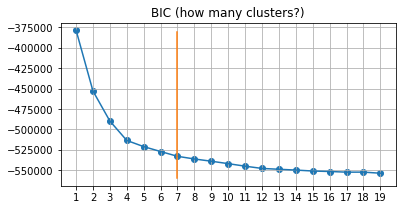

In [60]:
f, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(K,BIC)
ax.scatter(K,BIC)
ax.plot([n_clusters,n_clusters],[-560000,-380000])
ax.set_xticks(np.arange(1,20))
ax.set_title('BIC (how many clusters?)')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_22/uv_clusters6_bic.jpg', dpi=400)

In [61]:
cluster_mapU = np.nan*np.ones((len(lat1),len(lon1)))
cluster_mapV = np.nan*np.ones((len(lat1),len(lon1)))
cluster_mapUV = np.nan*np.ones((len(lat1),len(lon1)))
for i in range(len(labelsU)):
    this_lon = lon_train[i]
    this_lat = lat_train[i]
    loc_lon = np.where(lon1 == this_lon)[0]
    loc_lat = np.where(lat1 == this_lat)[0]
    cluster_mapU[loc_lat,loc_lon] = labelsU[i]
    cluster_mapV[loc_lat,loc_lon] = labelsV[i]
    cluster_mapUV[loc_lat,loc_lon] = labelsUV[i]

(-75.0, 75.0)

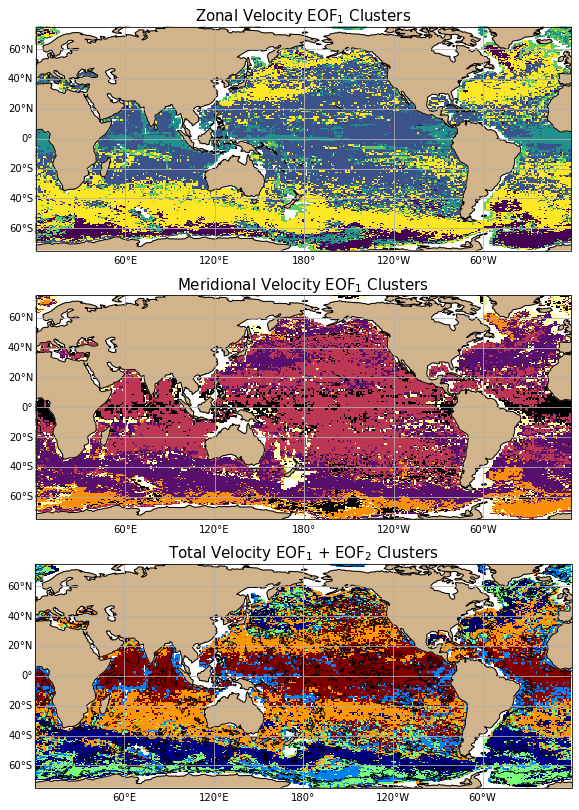

In [109]:
colors1=plt.get_cmap('viridis',n_clusters); colors2=plt.get_cmap('inferno',n_clusters); colors3=plt.get_cmap('jet',n_clusters)
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,14), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax1.pcolor(lon1,lat1,cluster_mapU, transform=ccrs.PlateCarree(), cmap=colors1, vmin=0, vmax=n_clusters) 
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines(); gl = ax1.gridlines(draw_labels=True); ax1.set_title(r'Zonal Velocity EOF$_1$ Clusters',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax1.set_ylim([-75,75])

ax2.pcolor(lon1,lat1,cluster_mapV, transform=ccrs.PlateCarree(), cmap=colors2, vmin=0, vmax=n_clusters) 
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines(); gl = ax2.gridlines(draw_labels=True); ax2.set_title(r'Meridional Velocity EOF$_1$ Clusters',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax2.set_ylim([-75,75])

ax3.pcolor(lon1,lat1,cluster_mapUV, transform=ccrs.PlateCarree(), cmap=colors3, vmin=0, vmax=n_clusters) 
ax3.contour(lon,lat,roughness,levels=[75],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax3.coastlines(); gl = ax3.gridlines(draw_labels=True); ax3.set_title(r'Total Velocity EOF$_1$ + EOF$_2$ Clusters',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax3.set_ylim([-75,75])

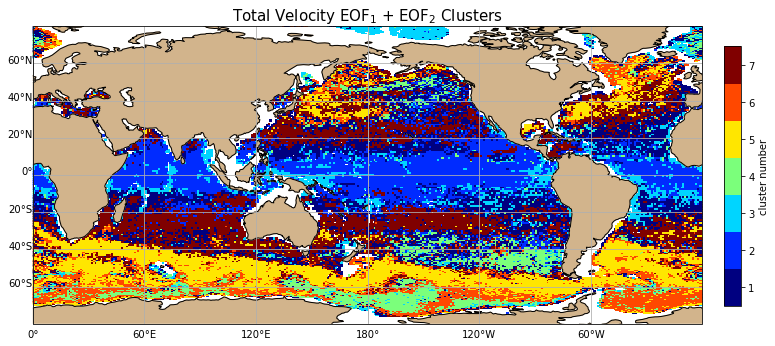

In [77]:
# colors3=plt.get_cmap('viridis',n_clusters)
colors3=plt.get_cmap('jet',n_clusters)
data_coords = {'latitude': lat1, 'longitude': lon1}
cluster_mapUV_da = xr.DataArray(data=cluster_mapUV, dims=['latitude', 'longitude'], coords=data_coords)
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
cc = cluster_mapUV_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=colors3, vmin=0, vmax=n_clusters, add_colorbar=False) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); 
ax.set_title(r'Total Velocity EOF$_1$ + EOF$_2$ Clusters',fontsize=15)
# ax.set_title(r'Roughness Clusters',fontsize=15)
gl.xlabels_top = False; ax.set_ylim([-80,80]) # gl.ylabels_right = False;

# ax.contour(lon,lat,roughness,levels=[75],colors='k',transform=ccrs.PlateCarree(),linewidths=1.25)

cbpos = [0.925, 0.2, 0.02, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='cluster number', ticks=np.arange(0.5,n_clusters,1))
cb.ax.set_yticklabels(['1','2','3','4','5','6','7']) 
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2023_01_03/clusters7.jpg', dpi=400)

Text(0, 0.5, 'Normalized Depth')

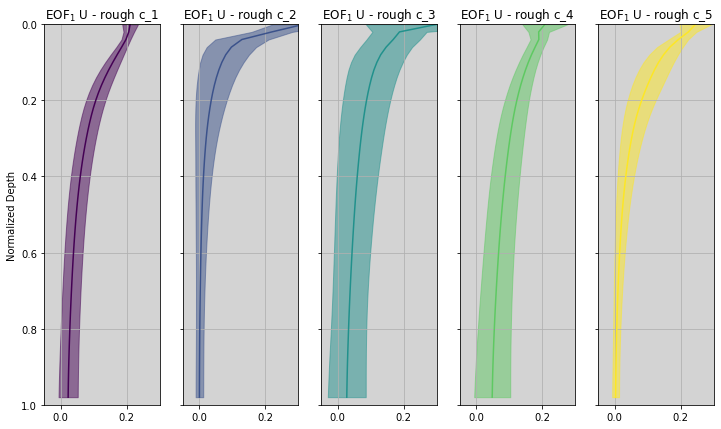

In [34]:
f, ax = plt.subplots(1,n_clusters,figsize=(12,7),sharey=True)
for i in range(n_clusters):
    li = X_trainU[:,labelsUV==i]
    ax[i].plot(np.nanmean(li,axis=1),rs_grid, color=colors3(i))
    ax[i].fill_betweenx(rs_grid,np.nanmean(li,axis=1)-np.nanstd(li,axis=1),\
                        x2=np.nanmean(li,axis=1)+np.nanstd(li,axis=1), color=colors3(i), alpha=0.5)
    ax[i].set_xlim([-0.05,0.3]); ax[i].set_ylim([0,1]); ax[i].grid()
    ax[i].set_title('EOF$_1$ U - rough c_' + str(i+1))
    ax[i].set_facecolor('#D3D3D3')
ax[0].invert_yaxis(); ax[0].set_ylabel('Normalized Depth')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_29/clusters5_roughness_eofu_profiles.jpg', dpi=300)

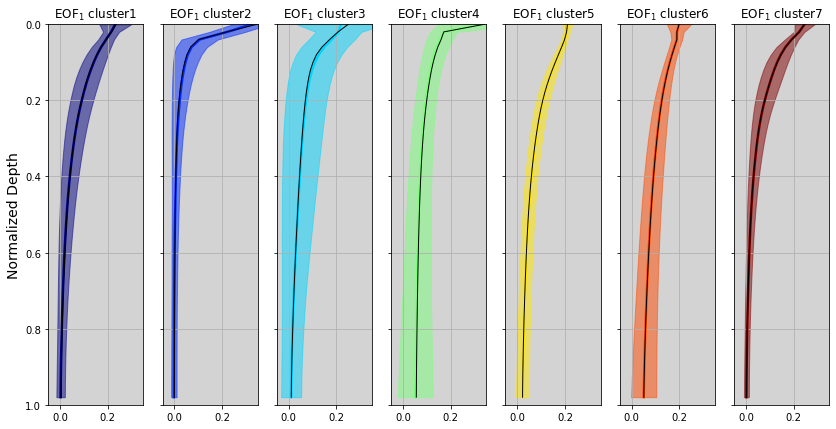

In [79]:
f, ax = plt.subplots(1,n_clusters,figsize=(14,7),sharey=True)
for i in range(n_clusters):
    li = X_trainV[:,labelsUV==i]
    li2 = X_trainU[:,labelsUV==i]
    ax[i].plot(np.nanmean(li,axis=1), rs_grid, color=colors3(i),linewidth=2.5)
    ax[i].plot(np.nanmean(li2,axis=1), rs_grid, color='k',linestyle='-',linewidth=1)
    ax[i].fill_betweenx(rs_grid,np.nanmean(li,axis=1)-np.nanstd(li,axis=1),\
                        x2=np.nanmean(li,axis=1)+np.nanstd(li,axis=1), color=colors3(i), alpha=0.5)
    ax[i].set_xlim([-0.05,0.35]); ax[i].set_ylim([0,1]); ax[i].grid()
    ax[i].set_facecolor('#D3D3D3')
    # ax[i].set_title('V Cluster ' + str(i+1))
    ax[i].set_title('EOF$_1$ cluster' + str(i+1))
ax[0].invert_yaxis(); ax[0].set_ylabel('Normalized Depth',fontsize=14)
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2023_01_03/clusters7_UV_profile_eof12.jpg', dpi=300)

In [64]:
# DISTRIBUTION OF ROUGHNESS/rho DECAY/MKE WITHIN CLUSTERS 
rough_in=[];decay_in=[];mke_in=[];botke_in=[];btbc_in=[];btbc_eke_in=[];scale_in=[];eke_in=[];pvar_in=[];EOFf_in=[];Lon_in=[];Lat_in=[];
for i in range(n_clusters):
    cluster_loc_i = np.where(cluster_mapUV == i)
    rough_in_i = []; decay_in_i = []; mke_in_i = []; botke_in_i = []; btbc_in_i = []; btbc_eke_in_i = []; scale_in_i = []; eke_in_i = []
    pvar_in_i = []; EOFf_in_i = []
    lon_in_i = []; lat_in_i = []
    for j in tqdm(range(len(cluster_loc_i[0]))):
        this_lon = Lon[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        this_lat = Lat[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        
        r_lon_in = np.where((lon > (this_lon - 0.2)) & (lon < (this_lon + 0.2)))
        r_lat_in = np.where((lat > (this_lat - 0.2)) & (lat < (this_lat + 0.2)))
        rough_in_i.append(np.nanmean(roughness[r_lat_in][:,r_lon_in]))
        
        # d_lon_in = np.where((lon_d > (this_lon - 0.5)) & (lon_d < (this_lon + 0.5)))
        # d_lat_in = np.where((lat_d > (this_lat - 0.5)) & (lat_d < (this_lat + 0.5)))
        # decay_in_i.append(np.nanmean(decay[d_lat_in][:,d_lon_in]))  
        d_lon_in = np.where((lon2 > (this_lon - 0.5)) & (lon2 < (this_lon + 0.5)))
        d_lat_in = np.where((lat2 > (this_lat - 0.5)) & (lat2 < (this_lat + 0.5)))
        decay_in_i.append(np.nanmean(decay_N2[d_lat_in][:,d_lon_in]))  
        
        m_lon_in = np.where((lonUV > (this_lon - 0.15)) & (lonUV < (this_lon + 0.15)))
        m_lat_in = np.where((latUV > (this_lat - 0.15)) & (latUV < (this_lat + 0.15)))
        mke_in_i.append(np.nanmean(MKE[m_lat_in][:,m_lon_in]))
        scale_in_i.append(np.nanmean(scale_ratio[m_lat_in][:,m_lon_in]))
        botke_in_i.append(np.nanmean(mean_bottom_ke[m_lat_in][:,m_lon_in]))

        e_lon_in = np.where((lonUV[::2] > (this_lon - 0.35)) & (lonUV[::2] < (this_lon + 0.35)))
        e_lat_in = np.where((latUV[::2] > (this_lat - 0.35)) & (latUV[::2] < (this_lat + 0.35)))
        eke_in_i.append(np.nanmean(EKE.data[e_lat_in][:,e_lon_in]))
        
        # btbc_in_i.append(np.nanmean(BT_BC_mean[r_lat_in][:,r_lon_in])) # same grid as roughness    
        
        e2_lon_in = np.where((lonUV > (this_lon - 0.35)) & (lonUV < (this_lon + 0.35)))
        e2_lat_in = np.where((latUV > (this_lat - 0.35)) & (latUV < (this_lat + 0.35)))
        btbc_eke_in_i.append(np.nanmean(BT_BC_EKE[e2_lat_in][:,e2_lon_in])) 
        
        # p_lon_in = np.where((lon1 > (this_lon - 0.25)) & (lon1 < (this_lon + 0.25)))
        # p_lat_in = np.where((lat1 > (this_lat - 0.25)) & (lat1 < (this_lat + 0.25)))
        # pvar_in_i.append(np.nanmean(cmEOF.pvarv.data[p_lat_in][:,p_lon_in]))
        
        EOFf_lon_in = np.where((lon1 > (this_lon - 0.25)) & (lon1 < (this_lon + 0.25)))
        EOFf_lat_in = np.where((lat_trim > (this_lat - 0.25)) & (lat_trim < (this_lat + 0.25)))
        EOFf_in_i.append(np.nanmean(pct_decay[EOFf_lat_in][:,EOFf_lon_in]))
        lon_in_i.append(this_lon)
        lat_in_i.append(this_lat)
        
    rough_in.append(rough_in_i)
    decay_in.append(decay_in_i)
    mke_in.append(mke_in_i)
    botke_in.append(botke_in_i)
    # btbc_in.append(btbc_in_i)
    btbc_eke_in.append(btbc_eke_in_i)
    scale_in.append(scale_in_i)
    eke_in.append(mke_in_i) # really MKE 
    # pvar_in.append(pvar_in_i)
    EOFf_in.append(EOFf_in_i)
    Lon_in.append(lon_in_i)
    Lat_in.append(lat_in_i)

100%|██████████| 7910/7910 [00:04<00:00, 1809.51it/s]


Text(0.5, 1.0, 'Cluster 1')

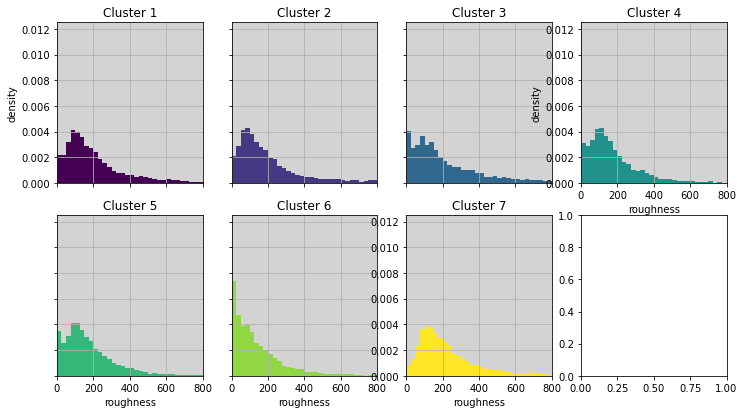

In [66]:
# ROUGHNESS 
f, ax = plt.subplots(2,4,figsize=(12,6.5)); gax = ax.flatten()
for i in range(n_clusters):
    nn = gax[i].hist(rough_in[i],bins=np.arange(0,1000,25),color=colors3(i),density=True)
    gax[i].set_ylim([0,0.0125]); 
    gax[i].set_xlim([0,800])
    if (i == 1) | (i == 2) | (i == 4) | (i == 5):
        gax[i].set_yticklabels('')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('density')
    if i > 2:
        gax[i].set_xlabel('roughness')
    if i < 3:
        gax[i].set_xticklabels('')
    gax[i].set_title('Cluster ' + str(i+1)); gax[i].set_facecolor('#D3D3D3'); gax[i].grid()
gax[0].set_title('Cluster ' + str(0+1))
# f.savefig('/Users/jakesteinberg/Documents/meetings/2022_08_NCAR/clusters6_roughness_dist.jpg', dpi=300)

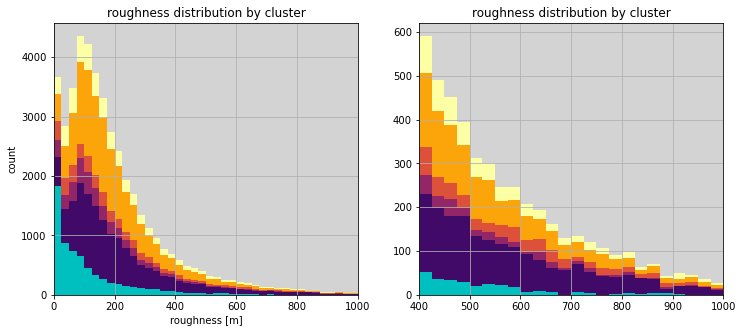

In [82]:
f, (ax,ax2) = plt.subplots(1,2,figsize=(12,5)); previous = 0; record= 0
normer = np.array([3.663e+03, 2.840e+03, 3.487e+03, 4.358e+03, 4.221e+03, 3.728e+03, 3.321e+03, 2.743e+03, 2.415e+03, 1.938e+03, 1.697e+03, 1.343e+03,
       1.127e+03, 9.620e+02, 7.700e+02, 6.880e+02, 5.910e+02, 4.910e+02, 4.510e+02, 3.940e+02, 3.120e+02, 3.020e+02, 2.470e+02, 2.460e+02,
       2.080e+02, 1.940e+02, 1.620e+02, 1.300e+02, 1.340e+02, 1.200e+02, 1.070e+02, 9.200e+01, 9.800e+01, 6.400e+01, 7.000e+01, 4.400e+01,
       4.900e+01, 4.600e+01, 3.600e+01, 2.800e+01, 2.300e+01, 1.800e+01, 1.400e+01, 1.600e+01, 2.100e+01, 1.200e+01, 6.000e+00, 5.000e+00,
       4.000e+00, 5.000e+00, 3.000e+00])
for i in range(n_clusters):
    nn = ax.hist(rough_in[i],bins=np.arange(0,1050,25),color=colors2(i),density=False,bottom=previous)
    previous = nn[0] + previous
    record = nn[0] + record
ax.hist(rough_in[0],bins=np.arange(0,1050,25),color='c',density=False,bottom=0)
ax.set_xlim([0,1000])
ax.set_facecolor('#D3D3D3')
ax.set_ylabel('count'); ax.set_xlabel('roughness [m]'); ax.set_title('roughness distribution by cluster'); ax.grid()
previous = 0
for i in range(n_clusters):
    nn = ax2.hist(rough_in[i],bins=np.arange(400,1050,25),color=colors2(i),density=False,bottom=previous)
    previous = nn[0] + previous
ax2.hist(rough_in[0],bins=np.arange(400,1050,25),color='c',density=False,bottom=0)
ax2.set_xlim([400,1000])
ax2.set_facecolor('#D3D3D3')
ax2.set_title('roughness distribution by cluster')
ax2.grid()
f.savefig('/Users/jakesteinberg/Documents/meetings/2022_08_NCAR/clusters6_roughness_cum_dist_2.jpg', dpi=300)

Text(0, 0.5, 'EOF1 decay frac')

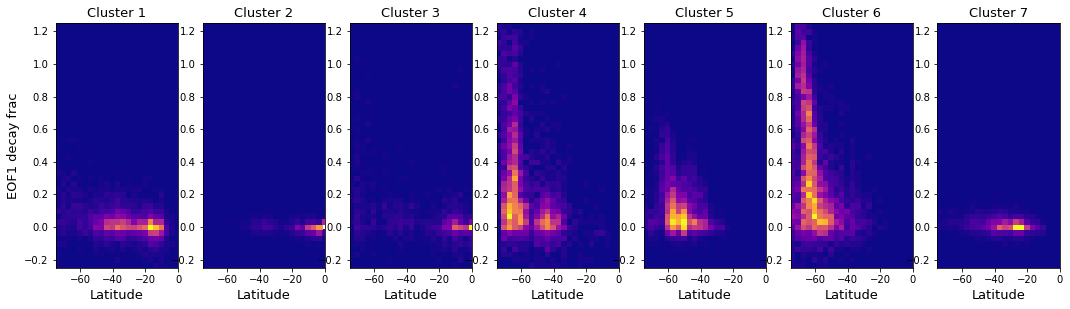

In [67]:
f, ax = plt.subplots(1,n_clusters,figsize=(18,4.5)); gax = ax.flatten()
for i in range(n_clusters):
    gax[i].hist2d(Lat_in[i],EOFf_in[i],bins=[45,45],range=[[-75, 75],[-0.25,1.25]],\
              density=True,cmin=0,cmax=0.8,cmap=plt.get_cmap('plasma'));
    # gax[i].hist2d(Lat_in[i],mke_in[i],bins=[45,45],range=[[-75, 75],[-0.25,10]],\
    #           density=True,cmin=0,cmax=0.8,cmap=plt.get_cmap('plasma'));
    # gax[i].hist2d(Lat_in[i],btbc_eke_in[i],bins=[55,55],range=[[-75, 75],[0,10]],\
    #           density=True,cmin=0,cmax=1,cmap=plt.get_cmap('plasma'));
    # if i > 2:
    gax[i].set_xlabel('Latitude',fontsize=13)
    # if (i == 0) | (i == 3):
        # gax[i].set_ylabel('EOF1 decay frac',fontsize=13)
        # gax[i].set_ylabel('MKE',fontsize=13)
        # gax[i].set_ylabel('BT/BC EKE',fontsize=13)
    gax[i].set_title('Cluster ' + str(i+1),fontsize=13)
    gax[i].set_xlim([-75,0])
gax[0].set_ylabel('EOF1 decay frac',fontsize=13)
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_22/clusters6_lat_mke.jpg', dpi=300)

In [68]:
n_roughs = 12
roughs = np.linspace(0,400,n_roughs+1)
rough_colors = plt.get_cmap('cool',n_roughs)

n_decays = 6
decays = np.linspace(0,200,n_decays+1)
decay_colors = plt.get_cmap('cool',n_decays)

n_mkes = 6
mkes = np.linspace(0,15,n_mkes+1)
mke_colors = plt.get_cmap('cool',n_mkes)

n_lats = 12
lats = np.linspace(0,80,n_lats+1)
lat_colors = plt.get_cmap('magma_r',n_lats)

Text(0.5, 1.0, 'MKE distribution within cluster3')

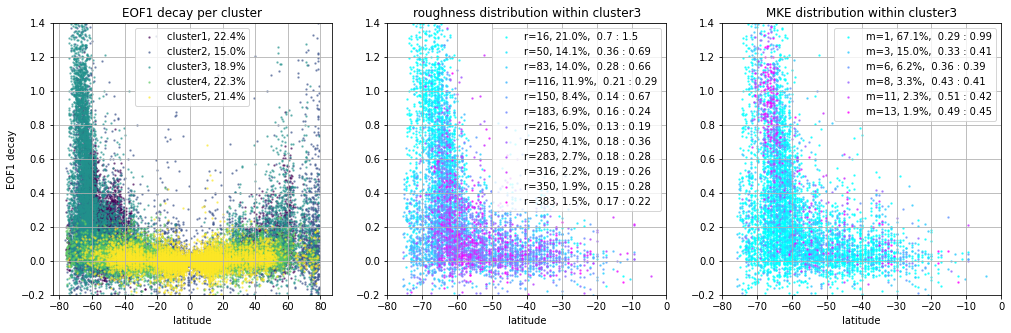

In [196]:
f, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(17,5))
for i in range(n_clusters):
    # ax.scatter(Lat_in[i],btbc_eke_in[i],color=colors3(i),s=2,alpha=0.25,\
    #            label='cluster'+str(i+1)+', ' + str(np.round(100*len(btbc_eke_in[i])/np.shape(X_pca_train)[0],1)) + '%')
    ax.scatter(Lat_in[i],EOFf_in[i],color=colors3(i),s=2,alpha=0.5, \
               label='cluster'+str(i+1)+', ' + str(np.round(100*len(EOFf_in[i])/np.shape(X_pca_train)[0],1)) + '%')
# ax.set_ylim([0,20])
# ax.set_ylabel('BT/BC EKE')
# ax.set_title('BT/BC EKE per cluster')
# ax.set_yscale('log')
ax.set_ylim([-0.2,1.4])
ax.set_ylabel('EOF1 decay')
ax.set_title('EOF1 decay per cluster')
ax.grid(); ax.legend()
ax.set_xlabel('latitude'); 

c_i = 2
for i in range(c_i,c_i+1):
    these_roughs = rough_in[i]
    this_lat = np.array(Lat_in[i])
    this_btbc = np.array(btbc_eke_in[i])
    this_eoff = np.array(EOFf_in[i])
    for j in range(n_roughs):
        inn = (these_roughs > roughs[j]) & (these_roughs < roughs[j+1])
        this_rough = np.array(these_roughs)[inn]
        # ax2.scatter(this_lat[inn],this_eoff[inn],color=rough_colors(j),s=3,alpha=0.75)
        ax2.scatter(this_lat[inn],this_eoff[inn],color=rough_colors(j),s=2,alpha=0.65,\
                    label='r='+str(np.int(np.nanmean([roughs[j],roughs[j+1]]))) + ', ' + \
                    str(np.round(100*len(this_rough)/len(these_roughs),1)) + '%,  ' + \
                    str(np.round(np.nanmean(this_eoff[inn]),2)) + ' : ' + str(np.round(np.nanstd(this_eoff[inn]),2)))
# ax2.set_ylim([0,20])
# ax2.set_yscale('log')
ax2.set_ylim([-0.2,1.4])
ax2.set_xlim([-80,0])
ax2.grid(); ax2.legend()
ax2.set_xlabel('latitude'); ax2.set_title('roughness distribution within cluster'+str(c_i+1))

for i in range(c_i,c_i+1):
    these_decays = decay_in[i]
    these_mkes = mke_in[i]
    this_lat = np.array(Lat_in[i])
    this_btbc = np.array(btbc_eke_in[i])
    this_eoff = np.array(EOFf_in[i])
    for j in range(n_decays):
        # inn = (these_decays > decays[j]) & (these_decays < decays[j+1])
        # this_decay = np.array(decay_in[i])[inn]
        inn = (these_mkes > mkes[j]) & (these_mkes < mkes[j+1])
        this_mke = np.array(mke_in[i])[inn]
        # ax3.scatter(this_lat[inn],this_btbc[inn],color=decay_colors(j),s=3,alpha=0.75,\
        #             label='d='+str(np.int(np.nanmean([decays[j],decays[j+1]]))) + ', ' + \
        #             str(np.round(100*len(this_decay)/len(these_decays),1)) + '%,  ' + \
        #             str(np.round(np.nanmean(this_btbc[inn]),2)) + ' : ' + str(np.round(np.nanstd(this_btbc[inn]),2)))
        ax3.scatter(this_lat[inn],this_eoff[inn],color=mke_colors(j),s=2,alpha=0.65,\
                    label='m='+str(np.int(np.nanmean([mkes[j],mkes[j+1]]))) + ', ' + \
                    str(np.round(100*len(this_mke)/len(these_mkes),1)) + '%,  ' + \
                    str(np.round(np.nanmean(this_eoff[inn]),2)) + ' : ' + str(np.round(np.nanstd(this_eoff[inn]),2)))
# ax3.set_ylim([0,20])
# ax2.set_yscale('log')
ax3.set_ylim([-0.2,1.4])
ax3.set_xlim([-80,0]); ax3.grid(); ax3.legend(); ax3.set_xlabel('latitude'); 
# ax3.set_title('N2 decay distribution within cluster'+str(c_i+1))
ax3.set_title('MKE distribution within cluster'+str(c_i+1))
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_11_22/cluster_btbc_bdown_r_mke_full_range.jpg', dpi=300)

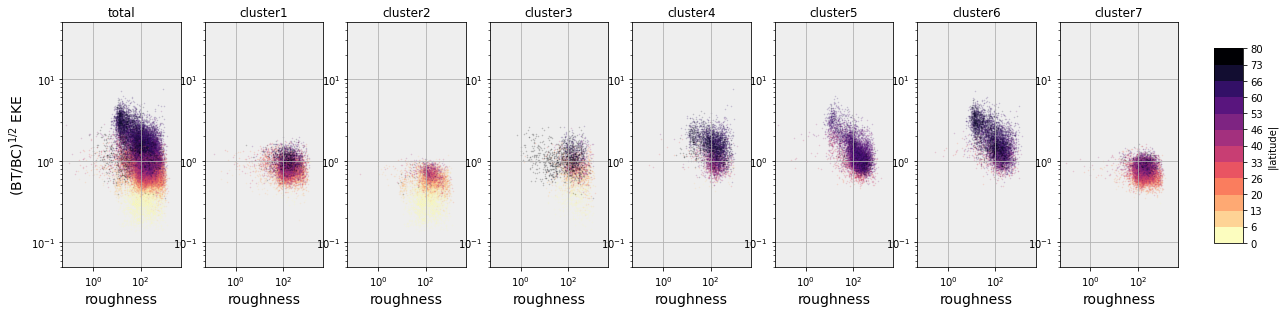

In [89]:
f, ax = plt.subplots(1,n_clusters+1,figsize=(20,4.5)); gax = ax.flatten()
x_bounds = [0.05,5000] # N2 = [1,500], MKE = [0.01,100], 
for i in range(n_clusters):
    these_lats = np.array(Lat_in[i])
    these_btbc = np.array(btbc_eke_in[i])
    these_bot = np.array(botke_in[i])
    these_scales = np.array(scale_in[i])
    these_roughs = np.array(rough_in[i])
    these_decays = np.array(decay_in[i])
    these_mkes = np.array(mke_in[i])
    
    for j in range(n_lats):
        inn = (np.abs(these_lats) > lats[j]) & (np.abs(these_lats) < lats[j+1])
        gax[i+1].scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        gax[0].scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_roughs[inn],np.sqrt(these_bot[inn]),s=1,color=lat_colors(j),alpha=0.2)
        # gax[0].scatter(these_roughs[inn],np.sqrt(these_bot[inn]),s=1,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_decays[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.2)
        # gax[0].scatter(these_decays[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_mkes[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.3)
        # gax[0].scatter(these_mkes[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.3)
        
    gax[i+1].set_yscale('log')
    gax[i+1].set_ylim([0.05,50])
    # gax[i+1].set_ylim([0.001,1])
    gax[i+1].grid()
    
    gax[i+1].set_xlim(x_bounds)
    gax[i+1].set_xscale('log')
    gax[i+1].set_xlabel('roughness',fontsize=14)
    # gax[i+1].set_xlabel('N2 decay ratio',fontsize=14)
    # gax[i+1].set_xlabel('MKE',fontsize=14)
    gax[i+1].set_facecolor('#eeeeee')
    gax[i+1].set_title('cluster'+str(i+1))
    
gax[0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=14)
gax[0].set_ylim([0.05,50])
# gax[0].set_ylabel('(bottomuv)$^{1/2}$ ',fontsize=14)
# gax[0].set_ylim([0.001,1])
gax[0].set_yscale('log')
gax[0].grid()

gax[0].set_xlim(x_bounds)
gax[0].set_xlabel('roughness',fontsize=14)
# gax[0].set_xlabel('N2 decay ratio',fontsize=14)
# gax[0].set_xlabel('MKE',fontsize=14)

gax[0].set_xscale('log'); gax[0].set_facecolor('#eeeeee'); gax[0].set_title('total')

cc = plt.scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),c=these_lats[inn],s=0,cmap=plt.get_cmap('magma_r',n_lats))
cbpos = [0.925, 0.2, 0.02, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='|latitude|', ticks=np.linspace(np.nanmin(these_lats[inn]),np.nanmax(these_lats[inn]),n_lats+1))
lat_strings = []
for i in range(len(lats)):
    lat_strings.append(str(np.int(lats[i])));
cb.ax.set_yticklabels(lat_strings);
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2023_01_03/clusters7_uv_eof12_mke_vs_btbc.jpg', dpi=300)

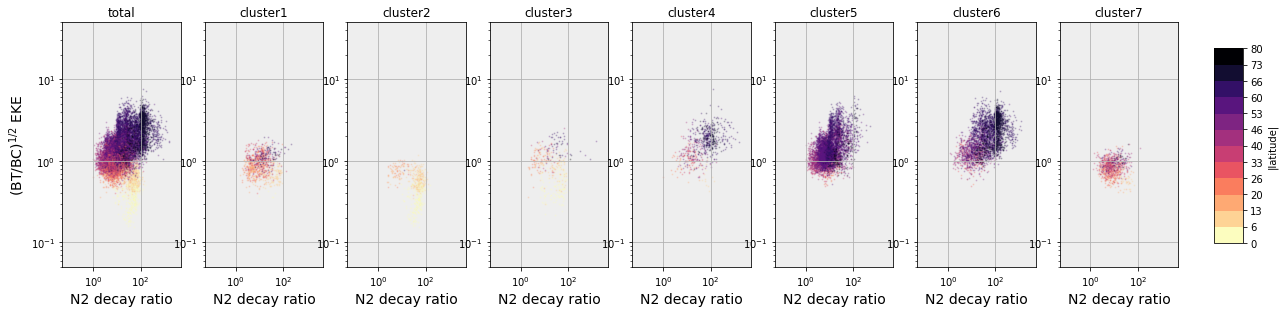

In [96]:
f, ax = plt.subplots(1,n_clusters+1,figsize=(20,4.5)); gax = ax.flatten()
x_bounds = [0.05,5000] # N2 = [1,500], MKE = [0.01,100], 
for i in range(n_clusters):
    these_lats = np.array(Lat_in[i])
    these_btbc = np.array(btbc_eke_in[i])
    these_bot = np.array(botke_in[i])
    these_scales = np.array(scale_in[i])
    these_roughs = np.array(rough_in[i])
    these_decays = np.array(decay_in[i])
    these_mkes = np.array(mke_in[i])
    
    for j in range(n_lats):
        inn = (np.abs(these_lats) > lats[j]) & (np.abs(these_lats) < lats[j+1])
        # gax[i+1].scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        # gax[0].scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_roughs[inn],np.sqrt(these_bot[inn]),s=1,color=lat_colors(j),alpha=0.2)
        # gax[0].scatter(these_roughs[inn],np.sqrt(these_bot[inn]),s=1,color=lat_colors(j),alpha=0.2)
        
        inn2 = np.sqrt(these_bot[inn]) > 0.025
        gax[i+1].scatter(these_decays[inn][inn2],np.sqrt(these_btbc[inn][inn2]),s=1,color=lat_colors(j),alpha=0.2)
        gax[0].scatter(these_decays[inn][inn2],np.sqrt(these_btbc[inn][inn2]),s=1,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_mkes[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.3)
        # gax[0].scatter(these_mkes[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.3)
        
    gax[i+1].set_yscale('log')
    gax[i+1].set_ylim([0.05,50])
    # gax[i+1].set_ylim([0.001,1])
    gax[i+1].grid()
    
    gax[i+1].set_xlim(x_bounds)
    gax[i+1].set_xscale('log')
    # gax[i+1].set_xlabel('roughness',fontsize=14)
    gax[i+1].set_xlabel('N2 decay ratio',fontsize=14)
    # gax[i+1].set_xlabel('MKE',fontsize=14)
    gax[i+1].set_facecolor('#eeeeee')
    gax[i+1].set_title('cluster'+str(i+1))
    
gax[0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=14)
gax[0].set_ylim([0.05,50])
# gax[0].set_ylabel('(bottomuv)$^{1/2}$ ',fontsize=14)
# gax[0].set_ylim([0.001,1])
gax[0].set_yscale('log')
gax[0].grid()

gax[0].set_xlim(x_bounds)
# gax[0].set_xlabel('roughness',fontsize=14)
gax[0].set_xlabel('N2 decay ratio',fontsize=14)
# gax[0].set_xlabel('MKE',fontsize=14)

gax[0].set_xscale('log'); gax[0].set_facecolor('#eeeeee'); gax[0].set_title('total')
cc = plt.scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),c=these_lats[inn],s=0,cmap=plt.get_cmap('magma_r',n_lats))
cbpos = [0.925, 0.2, 0.02, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='|latitude|', ticks=np.linspace(np.nanmin(these_lats[inn]),np.nanmax(these_lats[inn]),n_lats+1))
lat_strings = []
for i in range(len(lats)):
    lat_strings.append(str(np.int(lats[i])));
cb.ax.set_yticklabels(lat_strings);
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2023_01_10/clusters7_uv_eof12_N2_vs_btbc_2_5cms_cutoff.jpg', dpi=300)

Text(0.5, 0, 'Roughness')

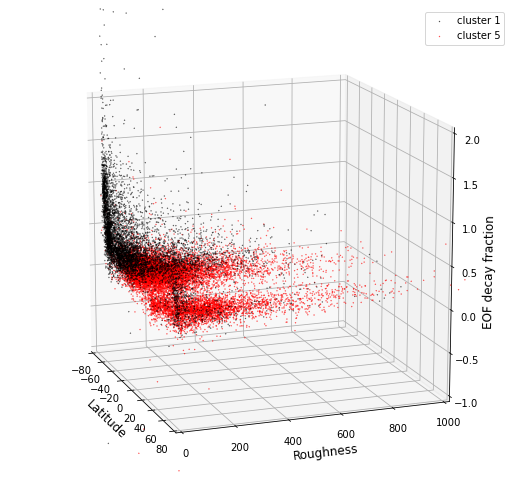

In [181]:
i0 = 0
i1 = 4
fig = plt.figure(figsize = (9, 9))
ax = plt.axes(projection ="3d")
ax.scatter3D(Lat_in[i0],rough_in[i0], EOFf_in[i0], s=0.1, color='k', label='cluster ' + str(i0+1))
ax.scatter3D(Lat_in[i1],rough_in[i1], EOFf_in[i1], s=0.1, color='r', label='cluster ' + str(i1+1))
ax.set_ylim([0,1000]); ax.set_zlim([-1,2]); ax.set_xlim([-80,80])
ax.legend()
ax.view_init(15, -20)
ax.set_xlabel('Latitude',fontsize=12); ax.set_zlabel('EOF decay fraction',fontsize=12); ax.set_ylabel('Roughness',fontsize=12)

In [593]:
# N2 DECAY 
fitd0 = -20; fitd1 = -400;
fit_ind = np.where((-1*N2_s_z < fitd0) & (-1*N2_s_z > fitd1))[0]
N2_z = -1*N2_s_z[fit_ind]
# fit_ind = np.where((N2_z < fitd0) & (N2_z > fitd1))[0]
decay = np.nan * np.ones((np.shape(N2_s)[1], np.shape(N2_s)[2]))
misfit = np.nan * np.ones(np.shape(decay))
for i in tqdm(range(np.shape(N2_s)[1])):
    for j in range(np.shape(N2_s)[2]):
        this_N2 = np.squeeze(N2_s[fit_ind,i,j])
        if np.sum(np.isnan(this_N2[0:5])) == 5:
            continue
        nancheck = np.where(this_N2 <= 0)[0]
        if len(nancheck) > 0: 
            upper_ocean_pos = np.where(this_N2[0:5] > 0)
            this_N2[nancheck] = np.nanmean(this_N2[upper_ocean_pos])
        # p = np.polyfit(N2_z[fit_ind], np.log(this_N2), 1)
        p = np.polyfit(N2_z, np.log(this_N2), 1)
        decay[i,j] = 1/p[0]

100%|██████████| 270/270 [00:05<00:00, 46.76it/s]


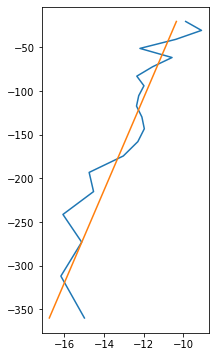

In [594]:
f, ax = plt.subplots(1,1,figsize=(3,6))
# ax.plot(np.log(this_N2),N2_z[fit_ind])
# ax.plot(np.polyval(p,N2_z[fit_ind]),N2_z[fit_ind])
ax.plot(np.log(this_N2),N2_z)
ax.plot(np.polyval(p,N2_z),N2_z)

311.941779405572


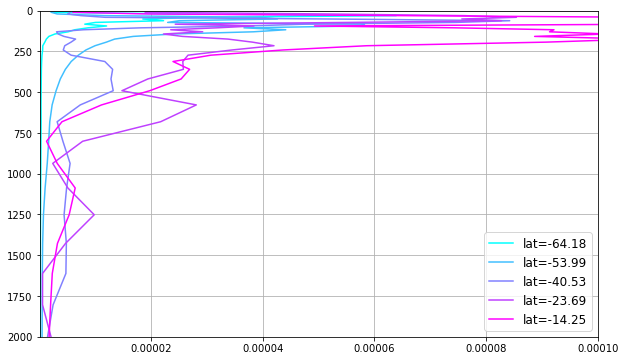

In [106]:
# N2_max = np.nanmax(N2_s,axis=0)
# N2_mid = N2_s[19] #32=2000m
print(N2_s_z[19])
li = [40,60,80,100,110]
nc = plt.get_cmap('cool',len(li))
f, ax = plt.subplots(1,1,figsize=(10,6))
for i in range(len(li)):
    ax.plot(N2_s[:,li[i],340],N2_s_z,label='lat='+str(np.round(lat2[li[i]],2)),color=nc(i))
ax.legend(fontsize=12); ax.set_ylim([0,2000]); ax.invert_yaxis(); ax.set_xlim([0.00000002,0.0001])
# ax.set_xscale('log')
ax.grid()

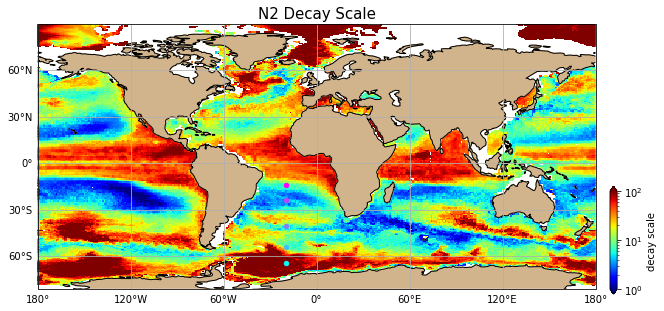

In [107]:
f, ax1 = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
# cc = ax1.pcolor(lon2,lat2,decay,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'), vmin=0, vmax=1000) 
cc = ax1.pcolor(lon2,lat2,N2_max/N2_mid,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('jet'),norm=LogNorm(vmin=1,vmax=100))
for i in range(len(li)):
    ax1.scatter(lon2[340],lat2[li[i]],s=20,color=nc(i),transform=ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax1.coastlines(); gl = ax1.gridlines(draw_labels=True); ax1.set_title('N2 Decay Scale',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
cbpos = [0.92, 0.12, 0.01, 0.3]; cax = f.add_axes(cbpos);
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='decay scale')